<img src="images/dq-logo-light-bg.png" alt="Dataquest Logo" width=200 align="left"/>
<br>
<br>

# Guided Project: Answering Business Questions using SQL

## 1. Introduction and Schema Diagram

In this Guided Project, we will be using the Chinook Database to answer some business questions using SQL. The Chinook data model represents a digital media store, including tables for artists, albums, media tracks, invoices and customers.
<br>
<br>
<details>
    <summary>Why the name Chinook?</summary>
    The name of this sample database was based on the Northwind database. <a href="http://en.wikipedia.org/wiki/Chinook_wind" title="Chinook Wind">Chinooks</a> are winds in the interior West of North America, where the Canadian Prairies and Great Plains meet various mountain ranges. Chinooks are most prevalent over southern Alberta in Canada. Chinook is a good name choice for a database that intents to be an alternative to Northwind.
</details>

Before we dive into it, let's take a look at the database schema.
![Chinook Database Schema](images/chinook-schema.svg "Chinook Database Schema")

**There are 11 tables in the Chinook database.**

1. **employee** table stores employees data such as employee id, last name, first name, etc. It also has a field named reports_to to specify who reports to whom.
2. **customer** table stores customers data.
3. **invoice** table stores invoice header data
4. **invoice_line** table stores the invoice <u title="The term “line item” refers to any service or product added to an invoice, along with any quantities, rates, and prices that pertain to them.">line items data</u>.
5. **artist** table stores artists data. It is a simple table that contains only artist_id and name.
6. **album** table stores data about a list of tracks. Each album belongs to one artist. However, one artist may have multiple albums.
7. **media_type** table stores media types such as MPEG audio and AAC audio file.
8. **genre** table stores music types such as rock, jazz, metal, etc.
9. **track** table store the data of songs. Each track belongs to one album.
10. **playlist** table store data about playlists. Each playlist contains a list of tracks. Each track may belong to multiple playlists. The relationship between the playlist table and track table is <u title="A many-to-many relationship refers to a relationship between tables in a database when a parent row in one table contains several child rows in the second table, and vice versa.">many-to-many</u>.
11. **playlist_track** table is used to reflect this relationship.

## 2. Creating Helper Functions

In this project, we'll:

* create some helper functions in python to save some time.
* use a context manager to handle the connection to the SQLite database.

Context managers make our life easy by taking care of opening and closing the connection to the database, as well as making sure we don't accidentally make changes to the database if one of our queries has an error.

**Instructions**

1. Import the SQLite, pandas and matplotlib modules, and use the magic command `%matplotlib inline` to make sure any plots render in the notebook.
2. Create a `run_query()` function, that takes a SQL query as an argument and returns a pandas dataframe of that query.
3. Create a `run_command()` function that takes a SQL command as an argument and executes it using the sqlite module.
4. Create a `show_tables()` function that calls the `run_query()` function to return a list of all tables and views in the database.
5. Run the `show_tables()` function.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## 3. Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

|Artist Name|Genre|
|---|---|
|Regal|Hip-Hop|
|Red Tone|Punk|
|Meteor and the Girls|Pop|
|Slim Jim Bites|Blues|

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

You'll need to write a query to find out which genres sell the most tracks in the USA, and then create a visualization of that data using pandas.

**Instructions**

1. Write a query that returns each genre, with the number of tracks sold in the USA:
  * in absolute numbers
  * in percentages.
2. Create a plot to show this data.
3. Write a paragraph that interprets the data and makes a recommendation for the three artists whose albums we should purchase for the store, based on sales of tracks from their genres.

In [2]:
albums_to_purchase = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


<details>
    <summary>Query Explanation</summary>
    
**Summary**

We created a subquery named `usa_tracks_sold` which lists all the invoice line data (track purchases) where the customer is from USA. After that we joined `track` and `genre` tables to group the data by `genre.name` and found the total tracks sold and the percentage of tracks sold.<br><br>
    
**Granular View**<br>

```sqlite
SELECT 
  * 
FROM 
  invoice_line
```
(4757 Rows)
```sqlite
SELECT 
  * 
FROM 
  invoice
```
(614 Rows)
```sqlite
SELECT 
  * 
FROM 
  invoice_line il 
  INNER JOIN invoice i on il.invoice_id = i.invoice_id
```
(4757 Rows)
```sqlite
SELECT 
  * 
FROM 
  customer
```
(59 Rows)
```sqlite
SELECT 
  * 
FROM 
  invoice_line il 
  INNER JOIN invoice i on il.invoice_id = i.invoice_id 
  INNER JOIN customer c on i.customer_id = c.customer_id
```
(4757 Rows)
```sqlite
SELECT 
  * 
FROM 
  invoice_line il 
  INNER JOIN invoice i on il.invoice_id = i.invoice_id 
  INNER JOIN customer c on i.customer_id = c.customer_id 
WHERE 
  c.country = "USA"
```
(1051 Rows)

We have saved a query that generates 1051 tracks sold in USA with the name `usa_tracks_sold`. And that query returns all columns in `invoice_line` table.

```sqlite
WITH usa_tracks_sold AS (
  SELECT 
    il.* 
  FROM 
    invoice_line il 
    INNER JOIN invoice i on il.invoice_id = i.invoice_id 
    INNER JOIN customer c on i.customer_id = c.customer_id 
  WHERE 
    c.country = "USA" -- 1051 tracks sold in the USA
)
```
```sqlite
SELECT 
  COUNT(uts.invoice_line_id) tracks_sold, -- 1051
  CAST(
    COUNT(uts.invoice_line_id) AS FLOAT -- 1051
  ) / (
    SELECT 
      COUNT(*) -- 1051
    FROM 
      usa_tracks_sold
      ) percentage_sold -- 1.0
FROM 
  usa_tracks_sold uts
```
(1 Row)
```sqlite
SELECT 
  * 
FROM 
  track
```
(3503 Rows)
```sqlite
SELECT 
  COUNT(uts.invoice_line_id) tracks_sold, -- 1051
  CAST(
    COUNT(uts.invoice_line_id) AS FLOAT -- 1051
  ) / (
    SELECT 
      COUNT(*) -- 1051
    FROM 
      usa_tracks_sold
      ) percentage_sold -- 1.0
FROM 
  usa_tracks_sold uts
  INNER JOIN track t on t.track_id = uts.track_id
```
(1 Row)
```sqlite
SELECT 
  * 
FROM 
  genre
```
(25 Rows)
```sqlite
SELECT 
  g.name genre, -- Rock (First value)
  COUNT(uts.invoice_line_id) tracks_sold, 
  -- 1051
  CAST(
    COUNT(uts.invoice_line_id) AS FLOAT -- 1051
    ) / (
    SELECT 
      COUNT(*) -- 1051
    FROM 
      usa_tracks_sold
  ) percentage_sold -- 1.0
FROM 
  usa_tracks_sold uts 
  INNER JOIN track t on t.track_id = uts.track_id 
  INNER JOIN genre g on g.genre_id = t.genre_id
```
(1 Row)
```sqlite
SELECT 
  g.name genre, 
  COUNT(uts.invoice_line_id) tracks_sold,
  CAST(
    COUNT(uts.invoice_line_id) AS FLOAT
    ) / (
    SELECT 
      COUNT(*) -- 1051
    FROM 
      usa_tracks_sold
  ) percentage_sold
FROM 
  usa_tracks_sold uts 
  INNER JOIN track t on t.track_id = uts.track_id 
  INNER JOIN genre g on g.genre_id = t.genre_id 
GROUP BY 
  1 
ORDER BY 
  2 DESC
```
(17 Rows)
```sqlite
SELECT 
  g.name genre, 
  COUNT(uts.invoice_line_id) tracks_sold,
  CAST(
    COUNT(uts.invoice_line_id) AS FLOAT
    ) / (
    SELECT 
      COUNT(*) -- 1051
    FROM 
      usa_tracks_sold
  ) percentage_sold
FROM 
  usa_tracks_sold uts 
  INNER JOIN track t on t.track_id = uts.track_id 
  INNER JOIN genre g on g.genre_id = t.genre_id 
GROUP BY 
  1 
ORDER BY 
  2 DESC
LIMIT 
  10
```
(10 Rows)

We combined `usa_tracks_sold` subquery with `track` and `genre` tables and grouped the aggregations: number of tracks sold, and percentage of tracks sold by the `genre` column. And we ordered it in descending order and limited the number of rows to 10 to find the top 10 genres.
</details>

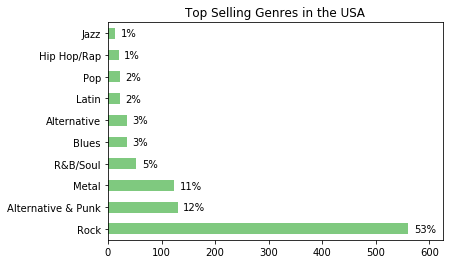

In [3]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

* Red Tone (Punk)
* Slim Jim Bites (Blues)
* Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'Rock' genre, which accounts for 53% of sales.

## 4. Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

**Instructions**

1. Write a query that finds the total dollar amount of sales assigned to each sales support agent within the company. Add any extra attributes for that employee that you find are relevant to the analysis.
2. Create a plot of the results of your query.
3. Write a short statement describing your results, and providing a possible interpretation.

In [4]:
employee_sales_performance = '''
WITH customer_support_rep_sales AS
    (
     SELECT
         i.customer_id,
         c.support_rep_id,
         SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 1,2
    )

SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(csrs.total) total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY 1;
'''

run_query(employee_sales_performance)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


<details>
    <summary>Query Explanation</summary>
    
**Summary**

We created a subquery `customer_support_rep_sales` that found the total sales by each support representative, Then we combined it with `employee` table to get their `first_name`, `last_name`, and `hire_date`.<br><br>
    
**Granular View**<br>

```sqlite
SELECT 
  * 
FROM 
  invoice
```
(614 Rows)
```sqlite
SELECT 
  i.customer_id, -- 18 (First value)
  SUM(i.total) total -- 4709.429999999994
FROM 
  invoice i
```
(1 Row)

The above query provides the total sales.

```sqlite
SELECT 
  * 
FROM 
  customer
```
(59 Rows)

```sqlite
SELECT 
  i.customer_id, -- 18 (First Value)
  c.support_rep_id, -- 3 (First Value)
  SUM(i.total) total -- 4709.429999999994
FROM 
  invoice i 
  INNER JOIN customer c ON i.customer_id = c.customer_id
```
```sqlite
SELECT 
  i.customer_id, 
  c.support_rep_id, 
  SUM(i.total) total 
FROM 
  invoice i 
  INNER JOIN customer c ON i.customer_id = c.customer_id 
GROUP BY 
  1
```
(59 Rows)

This query provides the total spending per customer.

```sqlite
SELECT 
  i.customer_id, 
  c.support_rep_id, 
  SUM(i.total) total 
FROM 
  invoice i 
  INNER JOIN customer c ON i.customer_id = c.customer_id 
GROUP BY 
  1, 
  2
```
(59 Rows)

If a customer had bought tracks from two support representatives then grouping by `customer_id` and `support_rep_id` would have reduced the number of rows. However, that is not the case here. As we can see the number of rows matches with the total number of customers. Therefore, every customer had only purchased tracks from one support representative. Therefore, grouping again by `support_rep_id` is not necessary.

Using the above query, let's a create a subquery with the name `customer_support_rep_sales` so that we can use it to find the total sales by support representatives.

```sqlite
WITH customer_support_rep_sales AS (
  SELECT 
    i.customer_id, 
    c.support_rep_id, 
    SUM(i.total) total 
  FROM 
    invoice i 
    INNER JOIN customer c ON i.customer_id = c.customer_id 
  GROUP BY 
    1, 
    2
)
```
```sqlite
SELECT 
  * 
FROM 
  employee
```
(8 Rows)
```sqlite
SELECT 
  * 
FROM 
  customer_support_rep_sales csrs 
  INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
```
(59 Rows)
```sqlite
SELECT 
  e.first_name || " " || e.last_name employee, -- Jane Peacock
  e.hire_date, -- 2017-04-01 00:00:00
  SUM(csrs.total) total_sales -- 4709.43
FROM 
  customer_support_rep_sales csrs 
  INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
```
(1 Row)
```sqlite
SELECT 
  e.first_name || " " || e.last_name employee, 
  e.hire_date, 
  SUM(csrs.total) total_sales 
FROM 
  customer_support_rep_sales csrs 
  INNER JOIN employee e ON e.employee_id = csrs.support_rep_id 
GROUP BY 
  1
```
(3 Rows)

If we have only just grouped by `support_rep_id` in our subquery `customer_support_rep_sales`, we don't need to separetely sum the csrs.total and group by `employee` in the above query. So let's remove the unnecessary group by.

```sqlite
WITH customer_support_rep_sales AS (
  SELECT 
    i.customer_id, 
    c.support_rep_id, 
    SUM(i.total) total 
  FROM 
    invoice i 
    INNER JOIN customer c ON i.customer_id = c.customer_id 
  GROUP BY 
    2
) 
SELECT 
  e.first_name || " " || e.last_name employee, 
  e.hire_date, 
  csrs.total total_sales 
FROM 
  customer_support_rep_sales csrs 
  INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
```
(3 Rows)

We found the total sales by each support representative using our subquery `customer_support_rep_sales`, Then we combined it with `employee` table to get their `first_name`, `last_name`, and `hire_date`.
</details>

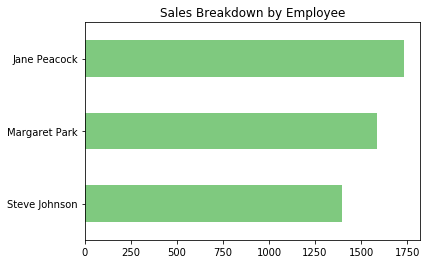

In [5]:
employee_sales = run_query(employee_sales_performance)

employee_sales.set_index("employee", drop=True, inplace=True)
employee_sales.sort_values("total_sales", inplace=True)
employee_sales.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
    colormap=plt.cm.Accent
)
plt.ylabel('')
plt.show()

While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.

## 5. Analyzing Sales by Country

Your next task is to analyze the sales data for customers from each different country. You have been given guidance to use the country value from the `customers` table, and ignore the country from the billing address in the `invoice` table.

In particular, you have been directed to calculate data, for each country, on the:

* total number of customers
* total value of sales
* average value of sales per customer
* average order value

**Instructions**

1. Write a query that collates data on purchases from different countries. For each country, include:
  * total number of customers
  * total value of sales
  * average value of sales per customer
  * average order value
2. Where a country has only one customer, collect them into an "Other" group.
3. The results should be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom.

In [6]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


<details>
    <summary>Query Explanation</summary>
    
**Summary**

We created a subquery `country_or_other` that changes the country name to `"Other"` if there is only a single customer from that country. Then we used this subquery to perform some aggregations and return the value in such a way that the `"Other"` country is displayed at the bottom row.<br><br>
    
**Granular View**<br>

```sqlite
SELECT 
  * 
FROM 
  invoice_line
```
(4757 Rows)
```sqlite
SELECT 
  * 
FROM 
  invoice
```
(614 Rows)
```sqlite
SELECT 
  * 
FROM 
  invoice_line il 
  INNER JOIN invoice i on il.invoice_id = i.invoice_id
```
(4757 Rows)
```sqlite
SELECT 
  * 
FROM 
  customer
```
(59 Rows)
```sqlite
SELECT 
  * 
FROM 
  invoice_line il 
  INNER JOIN invoice i on il.invoice_id = i.invoice_id 
  INNER JOIN customer c on i.customer_id = c.customer_id
```
(4757 Rows)

The above query is almost equal to our `usa_tracks_sold` subquery, the only major difference is that it is not filtering rows by country. Now we need to change `country` name to `others` for those countries which only have a single customer. To do this we have to use a type of statment called CASE statement. The CASE statement goes through conditions and returns a value when the first condition is met. To find the number of customers from each country, we can use the below query.

```sqlite
SELECT 
  (
    SELECT 
      count(*) 
    FROM 
      customer 
    WHERE 
      country = c.country
  ) 
FROM 
  customer c
```
(59 Rows)

The above query counts all the rows where the country is equal to the country outside the subquery. This might be a bit hard to comprehend at first glance. The subquery first selects all the rows from the `customer` table. Then the outer query selects all the rows from the `customer` table and gives it an alias called `c`. Now the `WHERE` clause in the subquery compares each country value with the country value of the outer query. For example, suppose the inner query returs 3 rows with USA, it checks each row for the first country value of outer query. Then the same process repeats and compares the result of inner query with the second country value of outer query and so on.

```sqlite
SELECT 
  CASE WHEN (
    SELECT 
      count(*) 
    FROM 
      customer 
    where 
      country = c.country
  ) = 1 THEN "Other" ELSE c.country END AS country, 
  c.customer_id, 
  il.* 
FROM 
  invoice_line il 
  INNER JOIN invoice i ON i.invoice_id = il.invoice_id 
  INNER JOIN customer c ON c.customer_id = i.customer_id
```
(4757 Rows)

We are renaming the `country` name using the `CASE` statement. If the inner query returns 1, we assign `"Other"` as country name. Otherwise, we will use the same country name. Now let's name this subquery `country_or_other` to use it to find: total number of customers, total value of sales, average value of sales per customer, and average order value for each country.

```sqlite
WITH country_or_other AS (
  SELECT 
    CASE WHEN (
      SELECT 
        count(*) 
      FROM 
        customer 
      where 
        country = c.country
    ) = 1 THEN "Other" ELSE c.country END AS country, 
    c.customer_id, 
    il.* 
  FROM 
    invoice_line il 
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id 
    INNER JOIN customer c ON c.customer_id = i.customer_id
)
```
```sqlite
SELECT 
  country, -- USA (First value)
  count(distinct customer_id) customers, -- 59
  SUM(unit_price) total_sales, -- 4709.429999999431
  SUM(unit_price) / count(distinct customer_id) customer_lifetime_value, -- 79.82084745761748
  SUM(unit_price) / count(distinct invoice_id) average_order -- 7.670081433223829
FROM 
  country_or_other
```
(1 Row)
```sqlite
SELECT 
  country, 
  count(distinct customer_id) customers, 
  SUM(unit_price) total_sales, 
  SUM(unit_price) / count(distinct customer_id) customer_lifetime_value, 
  SUM(unit_price) / count(distinct invoice_id) average_order 
FROM 
  country_or_other 
GROUP BY 
  country 
ORDER BY 
  total_sales DESC
```
(10 Rows)

Now the `"Other"` country is the top row. Since usually, we are more interested in individual countries. It would be good if we could push the `"Other"` country to the bottom row. There is a neat little trick to do that. The idea is to create a separate column called `sort`, And if the country name is equal to `"Other"`, we will assign `1` to the `sort` column, otherwise we will assign `0` to `sort` column. After that, all we need to do is, sort the table by the `sort` column in ascending order. 

```sqlite
SELECT 
  country, 
  count(distinct customer_id) customers, 
  SUM(unit_price) total_sales, 
  SUM(unit_price) / count(distinct customer_id) customer_lifetime_value, 
  SUM(unit_price) / count(distinct invoice_id) average_order, 
  CASE WHEN country = "Other" THEN 1 ELSE 0 END AS sort 
FROM 
  country_or_other 
GROUP BY 
  country 
ORDER BY 
  sort ASC, 
  total_sales DESC
```
(10 Rows)

Now since the above query also displays the sort column, we can place the above query as a subquery and use a `SELECT` statement on the subquery to display the relevant columns. Finally our query will look like this.

```sqlite
WITH country_or_other AS (
  SELECT 
    CASE WHEN (
      SELECT 
        count(*) 
      FROM 
        customer 
      where 
        country = c.country
    ) = 1 THEN "Other" ELSE c.country END AS country, 
    c.customer_id, 
    il.* 
  FROM 
    invoice_line il 
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id 
    INNER JOIN customer c ON c.customer_id = i.customer_id
) 
SELECT 
  country, 
  customers, 
  total_sales, 
  average_order, 
  customer_lifetime_value 
FROM 
  (
    SELECT 
      country, 
      count(distinct customer_id) customers, 
      SUM(unit_price) total_sales, 
      SUM(unit_price) / count(distinct customer_id) customer_lifetime_value, 
      SUM(unit_price) / count(distinct invoice_id) average_order, 
      CASE WHEN country = "Other" THEN 1 ELSE 0 END AS sort 
    FROM 
      country_or_other 
    GROUP BY 
      country 
    ORDER BY 
      sort ASC, 
      total_sales DESC
  );
```
</details>

## 6. Visualizing Sales by Country

Now that we have our data, we've been asked to create a series of visualizations which communicate our findings, and then make recommendations on which countries may have potential for growth, so the Chinook marketing team can create some new advertising campaigns.

**Instructions**

1. For each dimension, create a visualization which demonstrates the data we collated in the previous step.
  * You should decide whether the "Other" group is relevant to your analysis and make decisions on where to include it (if anywhere) in your visualizations.
2. Write a few sentences interpreting your data and visualizations, and make one or more recommendations to the marketing team on which countries have potential for growth.

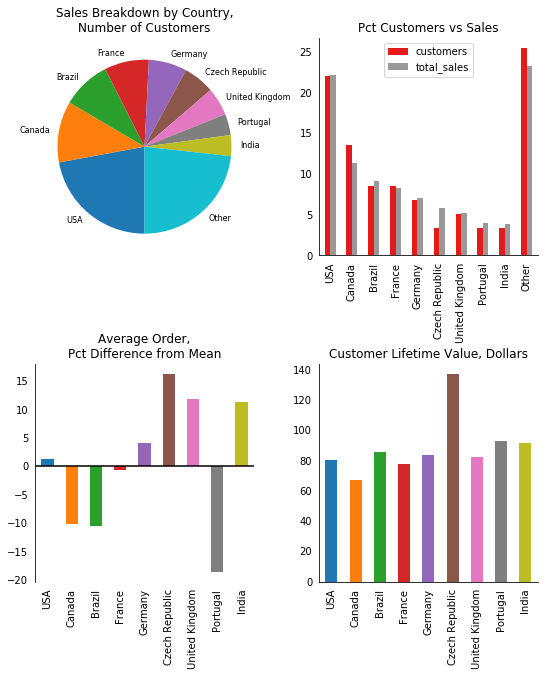

In [7]:
# NOTE 1
# ------
# ~/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:
# Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
#   warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "

# Please change False to "off" if you are getting any error or unexpected output.

# NOTE 2
# ------
# Accent colormap only contains 8 colors, therefore colors will be repeated if we use it for our data.
# Therefore, I chose to use tab10 colormap.


country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.tab10(i) for i in np.linspace(0, 1, country_metrics.shape[0])] # Refer to NOTE 2

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.tab10, # Refer to NOTE 2
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top=False, right=False, left=False, bottom=False) # Refer to NOTE 1
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top=False, right=False, left=False, bottom=False) # Refer to NOTE 1
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top=False, right=False, left=False, bottom=False) # Refer to NOTE 1
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

I would recommend to invest in Czech Republic. The reason is that, even though the customers are low in Czech Republic, the Sales is high. Czech Republic is at top when it comes to Customer Lifetime Value. So if the company can increase the customer base then it can easily attain more profits in Czech Republic than any other country.

## 7. Albums vs Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

* purchase a whole album
* purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

It is very common when you are performing an analysis to have 'edge cases' which prevent you from getting a 100% accurate answer to your question. In this instance, we have two edge cases to consider:

* Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
* Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.

In order to answer the question, we're going to have to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.

**Instructions**

1. Write a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:
  * Number of invoices
  * Percentage of invoices
2. Write one to two sentences explaining your findings, and making a prospective recommendation on whether the Chinook store should continue to buy full albums from record companies

In [8]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


<details>
    <summary>Query Explanation</summary>
    
**Summary**

We created a subquery `invoice_first_track` that finds the `first_track_id` from the `invoice_line` which we use to determine whether an invoice was album purchase or individual track purchases. Then we performed aggregations on the result to find out the number of invoices and the percentage of them separately for album purchase as well as individual track purchases.<br><br>
    
**Granular View**<br>

```sqlite
SELECT 
  * 
FROM 
  invoice_line
```
(4757 Rows)
```sqlite
SELECT 
  il.invoice_id invoice_id, -- 23 (First Value)
  MIN(il.track_id) first_track_id -- 1 (First Value)
FROM 
  invoice_line il
```
(1 Row)
```sqlite
SELECT 
  il.invoice_id invoice_id, 
  MIN(il.track_id) first_track_id 
FROM 
  invoice_line il 
GROUP BY 
  1
```
(614 Rows)

The above query finds the `track_id` with the lowest number in the `invoice_line` table for each `invoice_id`. However since an invoice can either be an album purchase or individual track purchases, we cannot say that every track_id we have is the first track of the album. It is only first, if the invoice was an album purchase. However, this `track_id` will help us to identify whether it was an album purchase or individual track purchases. And we can do so by getting all the tracks in an album which contains our first `track_id` and comparing it with all the tracks in the invoice, if both are returning the same set of tracks then it is an album purchase, otherwise it is individual track purchases. So let's save this as a subquery with the name `invoice_first_track`.

```sqlite
WITH invoice_first_track AS (
  SELECT 
    il.invoice_id invoice_id, 
    MIN(il.track_id) first_track_id 
  FROM 
    invoice_line il 
  GROUP BY 
    1
)
```
Since this is bit complicated query, we will separate the complicated part and use some abstraction to make it appear simple.
```sqlite
SELECT 
  ifs.*, 
  CASE WHEN (
    SELECT 
      t.track_id 
    FROM 
      track t 
    WHERE 
      t.album_id = (
        SELECT 
          t2.album_id 
        FROM 
          track t2 
        WHERE 
          t2.track_id = ifs.first_track_id
      ) 
    EXCEPT 
    SELECT 
      il2.track_id 
    FROM 
      invoice_line il2 
    WHERE 
      il2.invoice_id = ifs.invoice_id
  ) IS NULL 
  AND (
    SELECT 
      il2.track_id 
    FROM 
      invoice_line il2 
    WHERE 
      il2.invoice_id = ifs.invoice_id 
    EXCEPT 
    SELECT 
      t.track_id 
    FROM 
      track t 
    WHERE 
      t.album_id = (
        SELECT 
          t2.album_id 
        FROM 
          track t2 
        WHERE 
          t2.track_id = ifs.first_track_id
      )
  ) IS NULL THEN "yes" ELSE "no" END AS "album_purchase" 
FROM 
  invoice_first_track ifs

```
(614 Rows)

If we replace the query that identifies whether the tracks in the invoice and tracks in the album were same or not with an abstract name called `remaining_tracks` then the above query is very easy to understand and it immediately becomes too short.

```sqlite
SELECT 
  ifs.*, 
  CASE WHEN remaining_tracks IS NULL THEN "yes" ELSE "no" END AS "album_purchase" 
FROM 
  invoice_first_track ifs
```
(614 Rows)

Now let's leave the remaining_tracks query explanation there until we check it's outer query.

```sqlite
SELECT 
  * 
FROM 
  invoice
```
(614 Rows)
```sqlite
SELECT 
  album_purchase, -- yes
  COUNT(invoice_id) number_of_invoices, -- 614
  CAST(
    count(invoice_id) AS FLOAT
  ) / (
    SELECT 
      COUNT(*) 
    FROM 
      invoice
  ) percent -- 1.0
FROM 
  (
    SELECT 
      ifs.*, 
      CASE WHEN remaining_tracks IS NULL THEN "yes" ELSE "no" END AS "album_purchase" 
    FROM 
      invoice_first_track ifs
  )
```
(1 Row)
```sqlite
SELECT 
  album_purchase, 
  COUNT(invoice_id) number_of_invoices, 
  CAST(
    count(invoice_id) AS FLOAT
  ) / (
    SELECT 
      COUNT(*) 
    FROM 
      invoice
  ) percent 
FROM 
  (
    SELECT 
      ifs.*, 
      CASE WHEN remaining_tracks IS NULL THEN "yes" ELSE "no" END AS "album_purchase" 
    FROM 
      invoice_first_track ifs
  ) 
GROUP BY 
  album_purchase;
```
(2 Rows)
    Select all rows from our `invoice_first_track` subquery and if the result of `remaining_tracks` is `NULL` then assign `"yes"` to `album_purchase` else assign `"no"` to `album_purchase`. Find the number of invoices and there percentage of invoices grouped by `album_purchase` (yes and no). Yes, the entire query was as simple as that. So let's move on to the query that appears to be a complicated one. But before that, we need to make sure that we understand how `EXCEPT` works. `EXCEPT` is basically used to subtract one set of rows from another. Let's say a query `A` generated 5 rows (1, 2, 3, 4, 5) and query `B` generated 4 rows (1, 2, 3, 4). If we subtract `B` from `A`, we will get (5). That is, we will get rows that are in `A` but not in `B`. Now let's subtract `A` from `B`. We will get `NULL` because there are no rows in `B` that are not in a `A`. So let's say query `A` is `album_tracks` and `B` is `invoice_tracks`. So to be considered as `album_purchase`, `(A - B) AND (B - A)` should evaluate to True. However, as there is difference between the results of `A` and `B`, `(A - B) AND (B - A)` will become `5 AND NULL`. And this will evaluate to False. Now that we understand the concept, let's dive into understand `remaining_tracks`. We will explore from outer query to inner query by using abstract names.
```sqlite
SELECT 
  ifs.*, 
  CASE WHEN remaining_tracks IS NULL THEN "yes" ELSE "no" END AS "album_purchase" 
FROM 
  invoice_first_track ifs
```
```sqlite
SELECT 
  ifs.*, 
  CASE WHEN (
    album_tracks -- A
    EXCEPT -- -
    invoice_tracks -- B
  ) IS NULL 
  AND (
    invoice_tracks -- B
    EXCEPT -- -
    album_tracks -- A
  ) IS NULL THEN "yes" ELSE "no" END AS "album_purchase" 
FROM 
  invoice_first_track ifs
```
```sqlite
SELECT 
  ifs.*, 
  CASE WHEN (
    SELECT 
      t.track_id 
    FROM 
      track t 
    WHERE 
      t.album_id = album_id_first_track 
    EXCEPT 
    SELECT 
      il2.track_id 
    FROM 
      invoice_line il2 
    WHERE 
      il2.invoice_id = ifs.invoice_id
  ) IS NULL 
  AND (
    SELECT 
      il2.track_id 
    FROM 
      invoice_line il2 
    WHERE 
      il2.invoice_id = ifs.invoice_id 
    EXCEPT 
    SELECT 
      t.track_id 
    FROM 
      track t 
    WHERE 
      t.album_id = album_id_first_track
  ) IS NULL THEN "yes" ELSE "no" END AS "album_purchase" 
FROM 
  invoice_first_track ifs
```
```sqlite
SELECT 
  ifs.*, 
  CASE WHEN (
    SELECT 
      t.track_id 
    FROM 
      track t 
    WHERE 
      t.album_id = (
        SELECT 
          t2.album_id 
        FROM 
          track t2 
        WHERE 
          t2.track_id = ifs.first_track_id
      ) 
    EXCEPT 
    SELECT 
      il2.track_id 
    FROM 
      invoice_line il2 
    WHERE 
      il2.invoice_id = ifs.invoice_id
  ) IS NULL 
  AND (
    SELECT 
      il2.track_id 
    FROM 
      invoice_line il2 
    WHERE 
      il2.invoice_id = ifs.invoice_id 
    EXCEPT 
    SELECT 
      t.track_id 
    FROM 
      track t 
    WHERE 
      t.album_id = (
        SELECT 
          t2.album_id 
        FROM 
          track t2 
        WHERE 
          t2.track_id = ifs.first_track_id
      )
  ) IS NULL THEN "yes" ELSE "no" END AS "album_purchase" 
FROM 
  invoice_first_track ifs
```
Now that we have successfully understood, how that query works, let's do some number crunching. One thing to note is that, we won't be able to understand the output of the current query because the query does the same process for all the invoices. So let's pick a `first_track_id` to make it easier.
```sqlite
SELECT 
  t2.album_id 
FROM 
  track t2 
WHERE 
  t2.track_id = 1158 -- 91
```
(1 Row)
```sqlite
SELECT 
  t.track_id 
FROM 
  track t 
WHERE 
  t.album_id = (
    SELECT 
      t2.album_id 
    FROM 
      track t2 
    WHERE 
      t2.track_id = 1158
  )
```
(16 Rows)
```sqlite
SELECT 
  il2.track_id 
FROM 
  invoice_line il2 
WHERE 
  il2.invoice_id = 1
```
(16 Rows)
```sqlite
SELECT 
  t.track_id 
FROM 
  track t 
WHERE 
  t.album_id = (
    SELECT 
      t2.album_id 
    FROM 
      track t2 
    WHERE 
      t2.track_id = 1158
  ) 
EXCEPT 
SELECT 
  il2.track_id 
FROM 
  invoice_line il2 
WHERE 
  il2.invoice_id = 1
```
(0 Rows) - `NULL`

Now let's do the reverse (B - A).

```sqlite
SELECT 
  il2.track_id 
FROM 
  invoice_line il2 
WHERE 
  il2.invoice_id = 1 
EXCEPT 
SELECT 
  t.track_id 
FROM 
  track t 
WHERE 
  t.album_id = (
    SELECT 
      t2.album_id 
    FROM 
      track t2 
    WHERE 
      t2.track_id = 1158
  )
```
(0 Rows) - `NULL`

This is definitely an album purchase. However, let's proceed and verify that.

```sqlite
SELECT 
  ifs.*, 
  CASE WHEN (
    SELECT 
      t.track_id 
    FROM 
      track t 
    WHERE 
      t.album_id = (
        SELECT 
          t2.album_id 
        FROM 
          track t2 
        WHERE 
          t2.track_id = ifs.first_track_id
      ) 
    EXCEPT 
    SELECT 
      il2.track_id 
    FROM 
      invoice_line il2 
    WHERE 
      il2.invoice_id = ifs.invoice_id
  ) IS NULL 
  AND (
    SELECT 
      il2.track_id 
    FROM 
      invoice_line il2 
    WHERE 
      il2.invoice_id = ifs.invoice_id 
    EXCEPT 
    SELECT 
      t.track_id 
    FROM 
      track t 
    WHERE 
      t.album_id = (
        SELECT 
          t2.album_id 
        FROM 
          track t2 
        WHERE 
          t2.track_id = ifs.first_track_id
      )
  ) IS NULL THEN "yes" ELSE "no" END AS "album_purchase" -- yes
FROM 
  invoice_first_track ifs 
WHERE 
  ifs.invoice_id = 1
```
(1 Row)

And the above process happens with every single invoices so finding the rows of each tiny query is not easy for this one.
</details>

Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.